# Trabalho da 'turma de DM' - Data Mining do curso 'BI MASTER 2020-2'
Estudo de caso: Previsão de vendas de produtos específico em uma empresa varejista

In [1]:
import datetime
import math
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# chamamos o método 'set' do seaborn para ajustar os valores padrão de exibição dos gráficos
sns.set_theme()
sns.set()

In [23]:
# variáveis globais "constantes" apontando para os conjuntos de dados
PATH_DATASET="base"
PATH_DATASET_PRODUTO=os.path.join(PATH_DATASET,"BaseProduto.csv")
PATH_DATASET_VENDA=os.path.join(PATH_DATASET,"BaseVenda.csv")
PATH_DATASET_LOJA=os.path.join(PATH_DATASET,"BaseLoja.csv")

PATH_CACHE_VENDA_PREPARADO=os.path.join(PATH_DATASET,"venda_preparado.csv")

#### Caso o arquivo de cache exista (pré-processamento) então  [clique aqui continue o processamento com a carga arquivo de cache](#carga_cache)

## Carga dos conjuntos de dados: 'vendas', 'lojas' e 'produtos'

In [4]:
df_venda = pd.read_csv(PATH_DATASET_VENDA, delimiter='|', encoding='cp1252')

In [5]:
df_loja = pd.read_csv(PATH_DATASET_LOJA, delimiter='|', encoding='cp1252')

In [6]:
df_produto = pd.read_csv(PATH_DATASET_PRODUTO, delimiter='|', encoding='cp1252')

C:\Users\mrale\bin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df_produto.head()

,ARTIGO,ARTIGO_PAI,DESCRICAO,REFERENCIA,COR,TAMANHO,FORNECEDOR,NOME_FANTASIA_FORN,SECAO,GRUPO,...,ULTIMA_COMPRA,CD_FORNECEDOR,VITRINE_N1,VITRINE_N2,VITRINE_N3,SOLA,SALTO,FORRO,ESSOLA,PALMILHA
0,10000/00-0,10000/00-0,FIREZZI IN09 74008/7/9,0,48401-PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000/01-7,10000/00-0,FIREZZI IN09 74008/7/9,74008,CAM PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000/02-4,10000/00-0,FIREZZI IN09 74008/7/9,74009,CAM CASTOR.,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000/03-1,10000/00-0,FIREZZI IN09 74008/7/9,74007,CAM PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000/04-8,10000/00-0,FIREZZI IN09 74008/7/9,74009,CAM PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Filtramos o conjunto de dados para obter apenas calçados femininos vendidos no Rio de Janeiro


In [8]:
df_venda_preparado = df_venda[(df_venda.SECAO == 'CALCADOS') & 
                              (df_venda.GRUPO == 'FEMININO') &
                              (df_venda.CIDADE == 'RIO DE JANEIRO')]

In [9]:
print(df_venda.shape)
print(df_venda_preparado.shape)

(19559118, 15)
(2215699, 15)


##### Removemos colunas desnecessárias ao processamento

In [10]:
df_venda_preparado = df_venda.drop(['NumeroBoleta', 
                                    'Loja', 
                                    'UF', 
                                    'CIDADE',
                                    'BAIRRO', 
                                    'Produto_Codigo', 
                                    'SECAO', 
                                    'GRUPO', 
                                    'CATEGORIA', 
                                    'COR', 
                                    'TAMANHO', 
                                    'PrecoVenda', 
                                    'PrecoTransacao'], axis=1)

In [11]:
# verificamos se existem valores nulos nos dados
df_venda_preparado.isna().sum()

CriacaoReferencia    0
Quantidade           0
dtype: int64

In [12]:
# formatos padronizados para as datas
fmt_dt_iso='%Y-%m-%d'
fmt_dt_ano_mes='%Y-%m'
fmt_dt_ano_mes_semana='%Y-%m-%W'

In [14]:
# funções auxiliares para calcular as janelas de tempo
f_data_menos_uma_semana   = lambda d: d + relativedelta(weeks=-1)
f_data_menos_duas_semanas = lambda d: d + relativedelta(weeks=-2)
f_data_menos_um_ano       = lambda d: d + relativedelta(years=-1)

def formatar_data(df, coluna, formato):
    """Aplica um formato de data em uma coluna de um dataframe e a retorna."""
    return df[coluna].dt.strftime(formato)

def aplicar_funcoes(df, colunas_e_funcoes):
    """Percorre as tuplas de 'colunas_e_funcoes' e, para cada dicionario nela contidos, faz:
    - aplica a 'funcao' na coluna 'col_org', gravando o resultado na coluna 'col_dst' do dataframe 'df'
    """
    for e in colunas_e_funcoes:
        col_dst = e['col_dst']
        col_org = e['col_org']
        f_offset_data = e['funcao']
                
        # aplica a funcao 'f_offset_data' na coluna 'col_org' e 
        # salva o resultado na coluna 'col_dst'
        df[col_dst] = df[col_org].map(f_offset_data)
    
def aplicar_formatos_data(df, colunas_e_formatos):
    """Percorre as tuplas de 'colunas_e_formatos' e, para cada dicionario nela contidos, faz:
    - aplica o 'fmt_data' na coluna 'col_org', gravando o resultado na coluna 'col_dst' do dataframe 'df'
    """
    for e in colunas_e_formatos:
        col_dst = e['col_dst']
        col_org = e['col_org']
        fmt_data = e['fmt_data']
        
        # aplica o formato de data 'fmt_data' na coluna 'col_org' e 
        # salva o resultado na coluna 'col_dst'
        df[col_dst] = formatar_data(df, col_org, fmt_data)

In [15]:
# criamos uma coluna temporária de data da venda no padrão ISO
%time df_venda_preparado['DataVenda'] = pd.to_datetime(df_venda_preparado['CriacaoReferencia'],format=fmt_dt_iso)

Wall time: 2.01 s


In [16]:
# criamos uma coluna de ano-mês para facilitar as aglutinações dos dados
%time df_venda_preparado['AnoMes'] =  formatar_data(df_venda_preparado, 'DataVenda', fmt_dt_ano_mes)

Wall time: 2min 10s


In [17]:
# criamos colunas temporárias no dataframe para armazenar as datas de interesse
# essas colunas serão formatadas na sequência

# col_dst recebe funcao aplicada em col_org, na ordem das tuplas
colunas_e_offsets_de_tempo = (
    {'col_dst':'Data1SemanaAnterior',    'col_org': 'DataVenda',       'funcao': f_data_menos_uma_semana},
    {'col_dst':'Data2SemanaAnterior',    'col_org': 'DataVenda',       'funcao': f_data_menos_duas_semanas},
    {'col_dst':'DataAnoAnterior',        'col_org': 'DataVenda',       'funcao': f_data_menos_um_ano},
    {'col_dst':'DataAnoAnterior1Semana', 'col_org': 'DataAnoAnterior', 'funcao': f_data_menos_uma_semana},
    {'col_dst':'DataAnoAnterior2Semana', 'col_org': 'DataAnoAnterior', 'funcao': f_data_menos_duas_semanas}
)

# aplicamos as funções, medindo o tempo (demora bastante)
%time aplicar_funcoes(df_venda_preparado, colunas_e_offsets_de_tempo)

Wall time: 36min 54s


In [18]:
df_venda_preparado.shape

(19559118, 9)

In [19]:
# criamos colunas de datas específicas (formatadas) no dataframe para auxiliar a geração das janelas de
# tempo para o processamento dos algoritmos de regressão

# col_dst recebe formato de data aplicado em col_org, na ordem das tuplas
colunas_e_formatos = (
    {'col_dst':'AnoMesSemana',                   'col_org': 'DataVenda',              'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemana1SemanaAnterior',    'col_org': 'Data1SemanaAnterior',    'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemana2SemanaAnterior',    'col_org': 'Data2SemanaAnterior',    'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemanaAnoAnterior',        'col_org': 'DataAnoAnterior',        'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemanaAnoAnterior1Semana', 'col_org': 'DataAnoAnterior1Semana', 'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemanaAnoAnterior2Semana', 'col_org': 'DataAnoAnterior2Semana', 'fmt_data': fmt_dt_ano_mes_semana}
)

# aplicamos os formatos, medindo o tempo (demora bastante)
%time aplicar_formatos_data(df_venda_preparado, colunas_e_formatos)

Wall time: 12min 54s


In [20]:
df_venda_preparado.shape

(19559118, 15)

In [21]:
# removemos, do dataframe, as colunas que não são mais necessárias para processamento posterior
colunas_a_remover = ['CriacaoReferencia',
                     'DataVenda',
                     'Data1SemanaAnterior',
                     'Data2SemanaAnterior',
                     'DataAnoAnterior',
                     'DataAnoAnterior1Semana',
                     'DataAnoAnterior2Semana']

%time df_venda_preparado.drop(colunas_a_remover, axis=1, inplace=True)

Wall time: 42.2 s


In [22]:
df_venda_preparado.shape

(19559118, 8)

In [24]:
# como o tempo total de processamento até este momento é muito considerável,
# salvamos o resultado intermediário em um arquivo em disco, que servirá
# como cache e facilitará o processo de análise exploratória.
df_venda_preparado.to_csv(PATH_CACHE_VENDA_PREPARADO)

### <a id='carga_cache'></a> Carga do arquivo de cache, se existir, para ganhar tempo em análises subsequentes 

In [26]:
if os.path.exists(PATH_CACHE_VENDA_PREPARADO) and os.path.isfile(PATH_CACHE_VENDA_PREPARADO):
    df_venda_preparado = pd.read_csv(PATH_CACHE_VENDA_PREPARADO)

---

### Análise Estatística

#### Grafico da série temporal e da Autocorrelação - Mensal

In [27]:
df_venda_agrupado_mes = df_venda_preparado.groupby(by=['AnoMes'], as_index=False)['Quantidade'].sum()
df_venda_agrupado_mes = df_venda_agrupado_mes.sort_values(['AnoMes'])

C:\Users\mrale\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


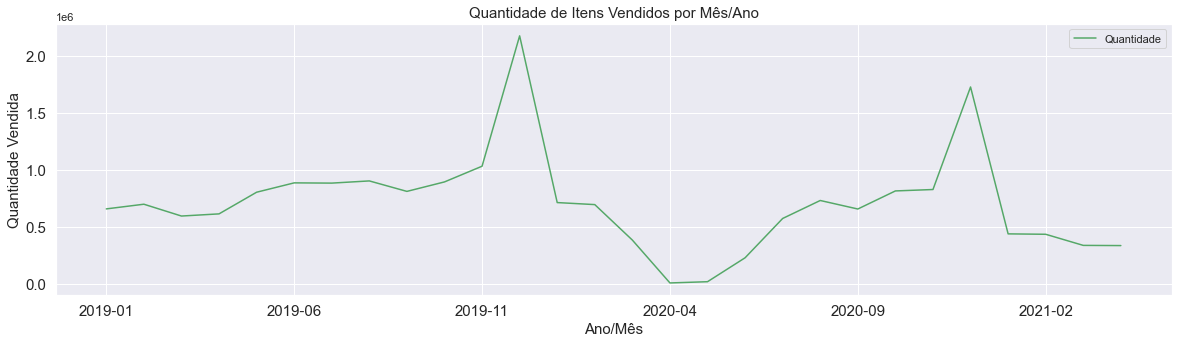

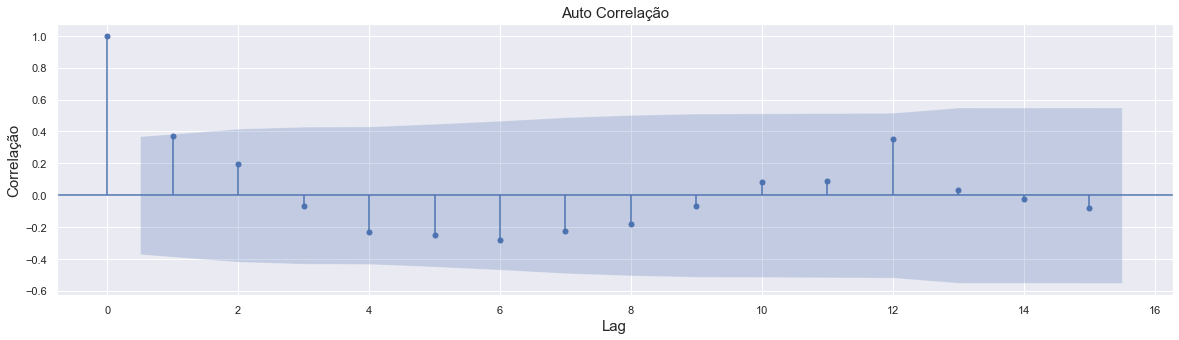

In [28]:
green = sns.color_palette("deep",8)[2]
blue = sns.color_palette("deep",8)[0]

fig, ax = plt.subplots(figsize=(20,5))
df_venda_agrupado_mes.plot(x="AnoMes",y="Quantidade",color="g", fontsize=15, ax=ax)
plt.xlabel("Ano/Mês",fontsize=15)
plt.title("Quantidade de Itens Vendidos por Mês/Ano", fontsize=15)
plt.ylabel("Quantidade Vendida", fontsize=15)
plt.show()


fig, ax = plt.subplots(figsize=(20,5))
plot_acf(df_venda_agrupado_mes.Quantidade, ax=ax)
plt.title("Auto Correlação", fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.ylabel("Correlação", fontsize=15)
plt.show()

#### Grafico da série temporal e da Autocorrelação - Semanal

In [29]:
df_venda_agrupado_semana = df_venda_preparado.groupby(by=['AnoMesSemana'], as_index=False)['Quantidade'].sum()

C:\Users\mrale\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


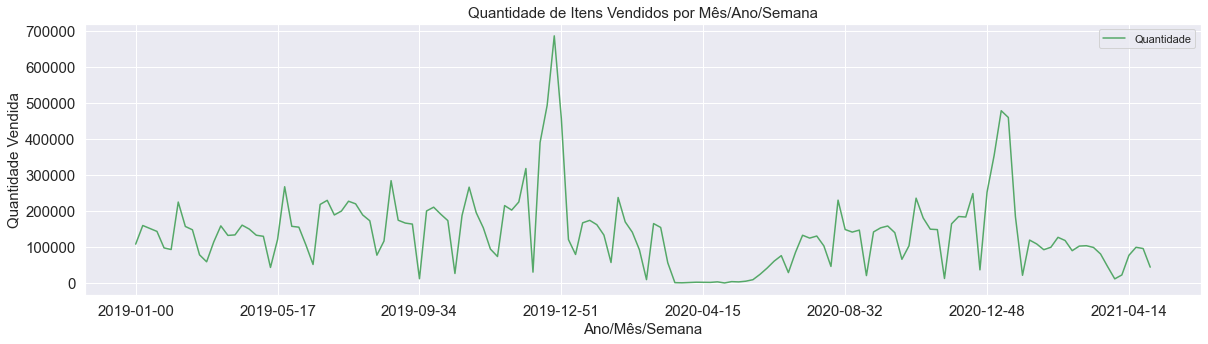

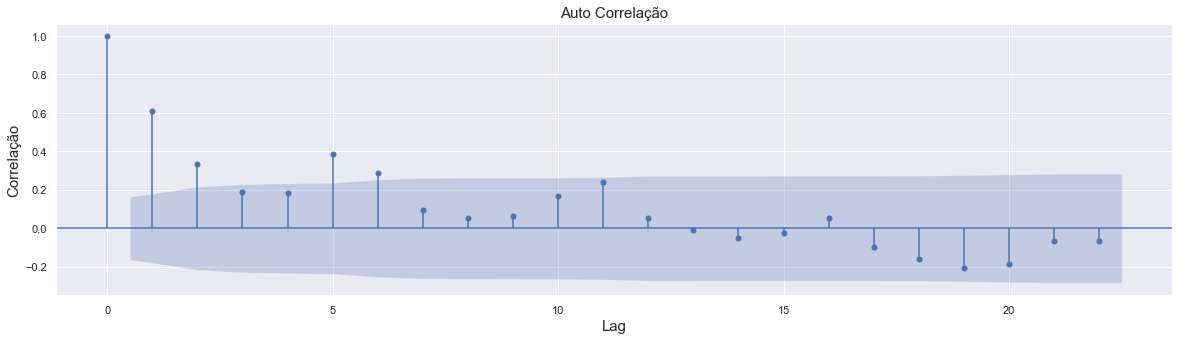

In [30]:
green = sns.color_palette("deep",8)[2]
blue = sns.color_palette("deep",8)[0]

fig, ax = plt.subplots(figsize=(20,5))
df_venda_agrupado_semana.plot(x="AnoMesSemana",y="Quantidade",color="g", fontsize=15, ax=ax)
plt.xlabel("Ano/Mês/Semana",fontsize=15)
plt.title("Quantidade de Itens Vendidos por Mês/Ano/Semana", fontsize=15)
plt.ylabel("Quantidade Vendida", fontsize=15)
plt.show()


fig, ax = plt.subplots(figsize=(20,5))
plot_acf(df_venda_agrupado_semana.Quantidade, ax=ax)
plt.title("Auto Correlação", fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.ylabel("Correlação", fontsize=15)
plt.show()

### Previsões Estatísticas

#### Média Móvel

In [31]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    

#### Média Móvel com janelas para agrupamento mês

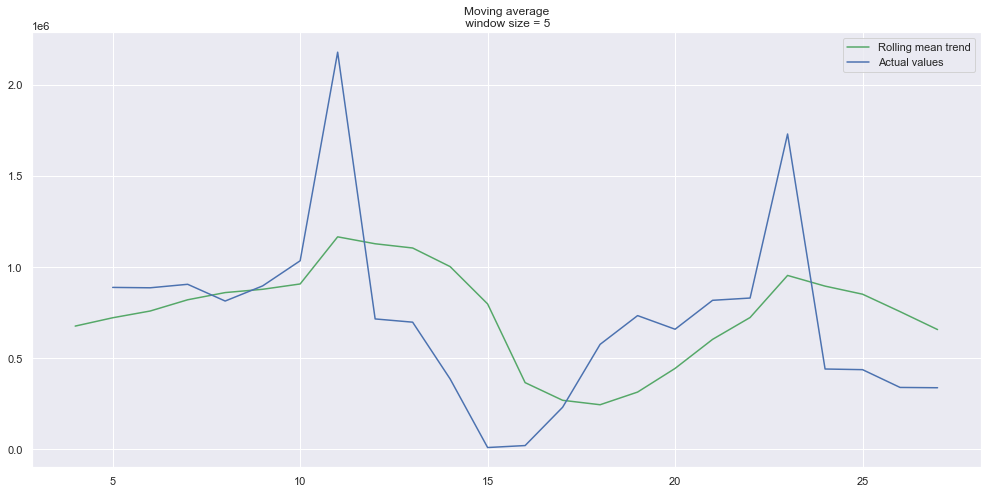

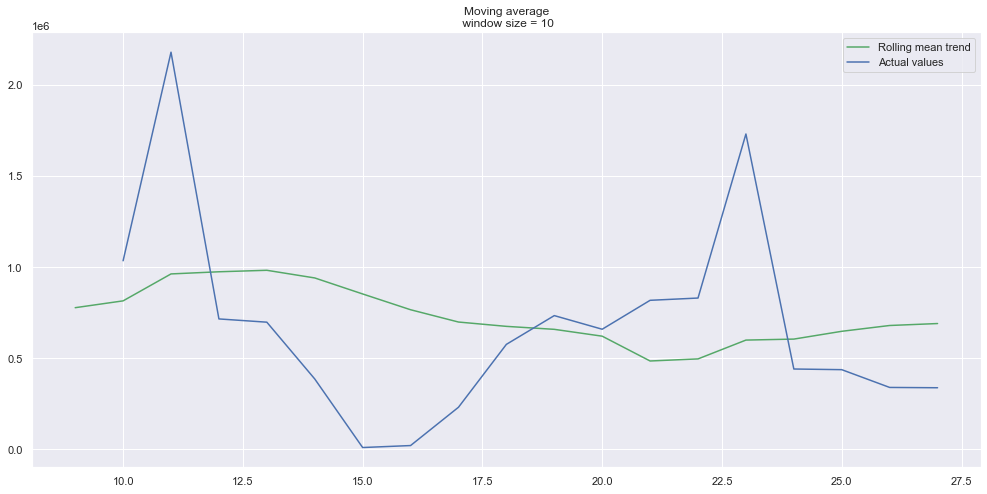

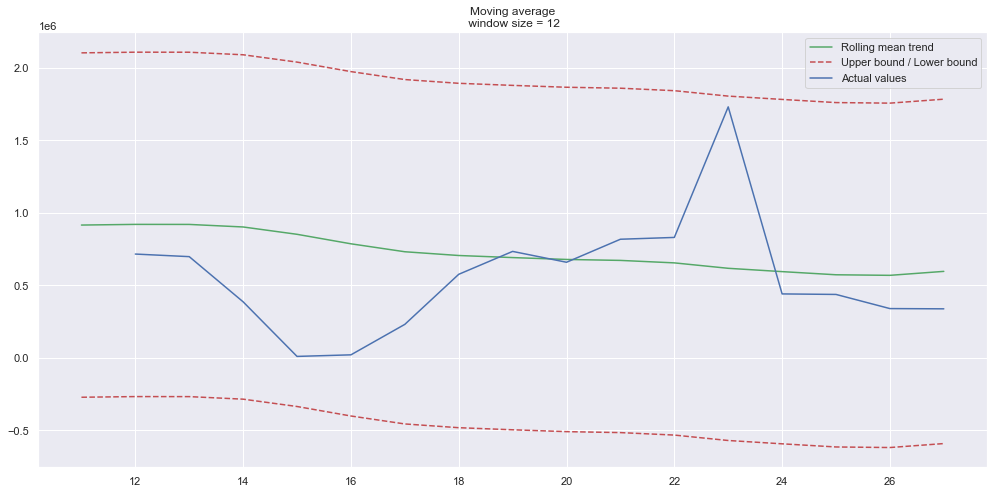

In [32]:
plot_moving_average(df_venda_agrupado_mes.Quantidade, 5)
plot_moving_average(df_venda_agrupado_mes.Quantidade, 10)
plot_moving_average(df_venda_agrupado_mes.Quantidade, 12, plot_intervals=True)

#### Média Móvel com janelas para agrupamento Semanal

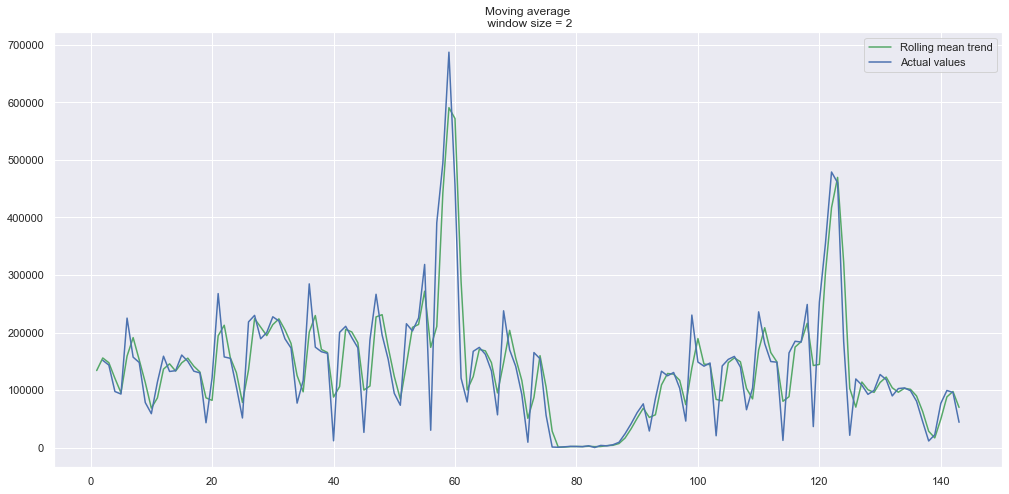

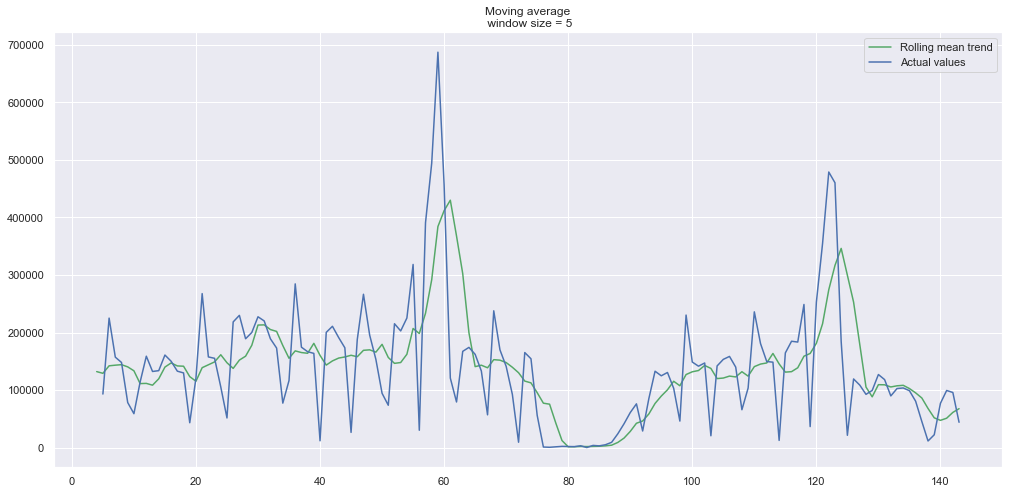

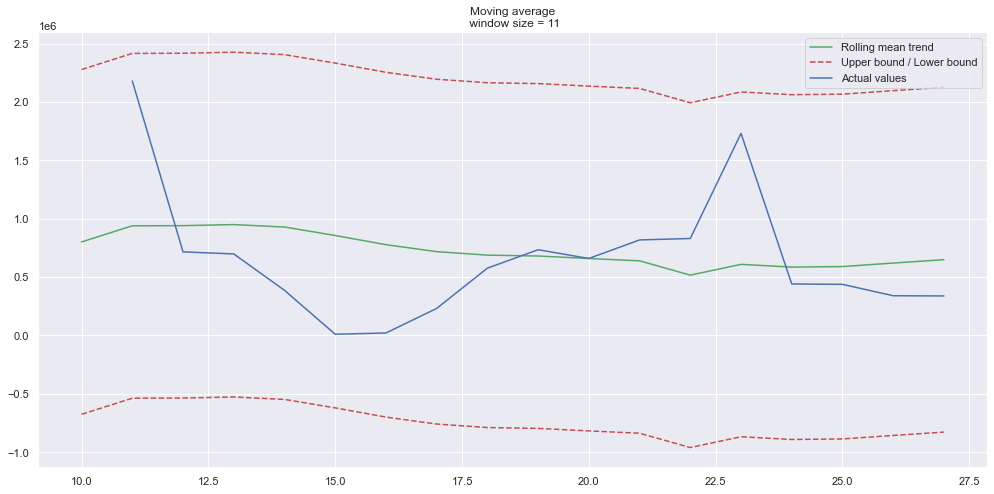

In [33]:
plot_moving_average(df_venda_agrupado_semana.Quantidade, 2)
plot_moving_average(df_venda_agrupado_semana.Quantidade, 5)
plot_moving_average(df_venda_agrupado_mes.Quantidade, 11, plot_intervals=True)

### Amortecimento Exponencial

In [34]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);



#### Mensal

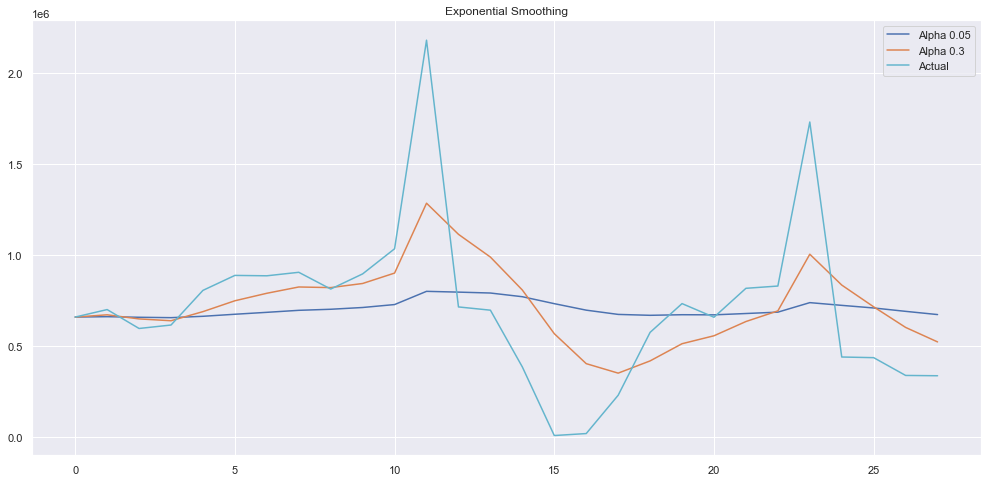

In [35]:
plot_exponential_smoothing(df_venda_agrupado_mes.Quantidade, [0.05, 0.3])

#### Semanal

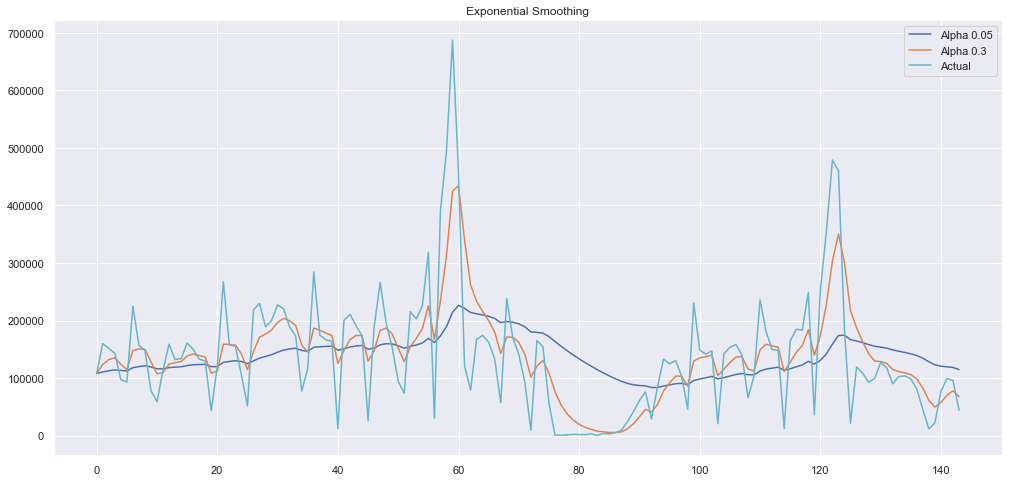

In [36]:
plot_exponential_smoothing(df_venda_agrupado_semana.Quantidade, [0.05, 0.3])

### ARIMA

MSE error: 7435909113.512931


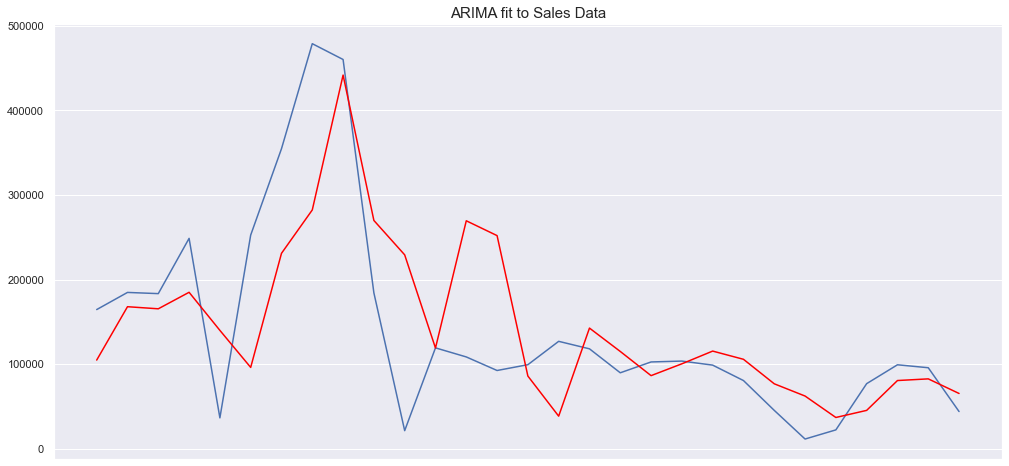

In [37]:
X = df_venda_agrupado_semana["Quantidade"].values

split = int(0.8*len(X))
train, test = X[0:split], X[split:]

history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
    
	obs = test[t]
	history.append(obs)
mse = mean_squared_error(test, predictions)

print(f"MSE error: {mse}")

plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit to Sales Data",fontsize=15)
plt.xticks([])
plt.show()

## Previsões Machine Learning 

#### Todas as vendas realizadas agrupadas por semana

In [39]:
df_venda_historico_agrupado = df_venda_preparado.groupby(by=['AnoMesSemana'], as_index=False)['Quantidade'].sum()

#### Métricas de Erro

In [40]:
def calcula_metricas_erro(y_pred,y_test, number_features):
    rmse = math.sqrt(mean_squared_error(y_pred,y_test))
    print('RMSE: ', rmse)
    
    mse = mean_squared_error(y_pred,y_test)
    print('MSE: ',mse)    
    
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('MAPE: ',mape, '%')
    
    r2 = r2_score(y_pred,y_test)
    print('R2 Score: ', r2)
    
    if (number_features is not None and number_features > 0): 
        number_samples = len(y_pred)
        adj_r2_score = 1-(1-r2)*(number_samples-1)/(number_samples-number_features-1)
        print('R2 Ajustado: ', adj_r2_score)
    

In [41]:
def mostra_grafico_previsao(y_pred, y_test):
    plt.plot(y_pred, label='previsto', marker='o')
    plt.plot(y_test, label='real', marker='+')
    plt.ylabel("Venda")
    plt.title("Previsão x Vendas")
    plt.legend()
    plt.show()

#### Montagem dos diferentes datasets para treino 

##### Dados da série histórica com a janela informada

In [42]:
def monta_dataset_por_janela(dataset=None, window=12):
    dataSize = len(dataset)
    X = []
    y = []
    for i in range(window, dataSize):
        X.append(dataset.iloc[i-window:i, 1])
        y.append(dataset.iloc[i, 1])
    X, y = np.array(X), np.array(y)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return x_train, x_test, y_train, y_test
    

##### Penúltima e antepenúltima semana/ mesma semana do ano anterior / penúltima e antepenúltima semana do ano anterior.

In [43]:
def monta_dataset_ano_anterior(dataset):
    df_venda_ml = dataset[dataset.AnoMesSemana >= '2020-01-02'].sort_values(['AnoMesSemana'])
    df_venda_agrupado_ml = df_venda_ml.groupby('AnoMesSemana', as_index=False).agg({
        'Quantidade':'sum',
        'AnoMesSemana1SemanaAnterior': 'max',
        'AnoMesSemana2SemanaAnterior': 'max',
        'AnoMesSemanaAnoAnterior': 'max',
        'AnoMesSemanaAnoAnterior1Semana':'max',
        'AnoMesSemanaAnoAnterior2Semana':'max'})
    
    df_venda_ml_final = pd.merge(df_venda_agrupado_ml, df_venda_historico_agrupado, left_on="AnoMesSemanaAnoAnterior", right_on="AnoMesSemana", suffixes=("","_AnoAnterior"))

    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemanaAnoAnterior1Semana", right_on="AnoMesSemana", suffixes=("","_AnoAnterior1Semana"))
    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemanaAnoAnterior2Semana", right_on="AnoMesSemana", suffixes=("","_AnoAnterior2Semana"))
    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemana1SemanaAnterior", right_on="AnoMesSemana", suffixes=("","_1SemanaAnterior"))
    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemana2SemanaAnterior", right_on="AnoMesSemana", suffixes=("","_2SemanaAnterior"))
    
    df_venda_ml_final = df_venda_ml_final[['AnoMesSemana','Quantidade_1SemanaAnterior','Quantidade_2SemanaAnterior','Quantidade_AnoAnterior','Quantidade_AnoAnterior1Semana','Quantidade_AnoAnterior2Semana','Quantidade']]
    
    np_dataset =  df_venda_ml_final.to_numpy()
    X = np_dataset[:,1:-1]
    y = np_dataset[:,-1]
    
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return x_train, x_test, y_train, y_test

##### Random Forest

In [44]:
def train_predict_random_forest(x_train, x_test, y_train, y_test):
    regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    calcula_metricas_erro(y_pred=y_pred, y_test=y_test,number_features=x_test.shape[1])
    mostra_grafico_previsao(y_pred=y_pred, y_test=y_test)

---

### Treino e Teste dos Modelos de ML

#### Random Forest

##### Dados preparados do ano anterior e corrente

RMSE:  34402.95280551874
MSE:  1183563161.73875
MAPE:  61.64210862685808 %
R2 Score:  -0.701025118509599
R2 Ajustado:  -1.5515376777643985


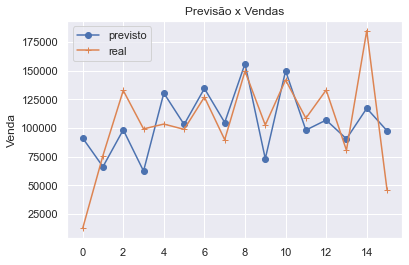

In [45]:
x_train, x_test, y_train, y_test = monta_dataset_ano_anterior(dataset=df_venda_preparado)
train_predict_random_forest(x_train, x_test, y_train, y_test)

##### Dados Obtidos por Janelas de Tempo

##### Janela 12 semanas

RMSE:  73092.20201161665
MSE:  5342469994.906977
MAPE:  456.17211823466823 %
R2 Score:  0.301883577846332
R2 Ajustado:  -0.2965019268568121


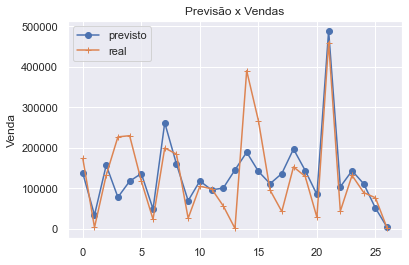

In [46]:
x_train, x_test, y_train, y_test = monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=12)
train_predict_random_forest(x_train, x_test, y_train, y_test)

##### Janela 24 semanas

RMSE:  70561.33188059759
MSE:  4978901556.763837
MAPE:  329.9348253795239 %
R2 Score:  0.2934206494924353
R2 Ajustado:  17.251325061673988


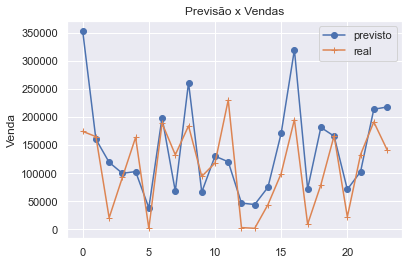

In [47]:
x_train, x_test, y_train, y_test = monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=24)
train_predict_random_forest(x_train, x_test, y_train, y_test)

##### Janela 36 semanas

RMSE:  73634.60894993544
MSE:  5422055635.209912
MAPE:  784.2143574576595 %
R2 Score:  0.3902603230460959
R2 Ajustado:  1.8536355477354658


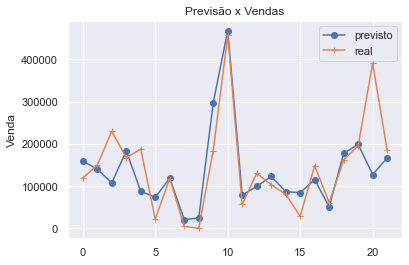

In [48]:
x_train, x_test, y_train, y_test = monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=36)
train_predict_random_forest(x_train, x_test, y_train, y_test)

##### Janela 52 semanas (aproximadamente 1 ano)

RMSE:  69646.01649264431
MSE:  4850567613.293684
MAPE:  928.3213925808329 %
R2 Score:  -0.5120723822672522
R2 Ajustado:  1.8005089082591335


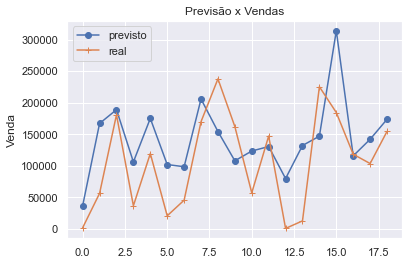

In [49]:
x_train, x_test, y_train, y_test = monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=52)
train_predict_random_forest(x_train, x_test, y_train, y_test)

----

---